# Quantum computing

This is an attempt to use a new method to solve the puzzle, using QC to solve the SAT definition, which is already provided by the thesis.

## Old solution

Using the old solution as much as possible, so it's beneficial to first run `./install.sh` (or manually run what's needed from it; MiniSAT is thankfully still installable from the same URL in the end of 2024). Then, the notebook can be run in this environment:

```sh
export ETERNITY_BIN=$PWD/bin
export ETERNITY_PROGRAMS=$PWD/programs
export PATH=$PATH:$ETERNITY_BIN:$ETERNITY_PROGRAMS

jupyter notebook --ip=127.0.0.1 --port=8888 --no-browser
```

Generating a random game (using the minimalistic size $2x2x2$ (width $x$ height $x$ symbols) to go easy on QC) and solving it using MiniSAT:

In [1]:
!eternity gen 2 2 2

start Thu Jan 23 11:57:09 2025

generuji nahodnou plochu... OK

konec Thu Jan 23 11:57:09 2025

trvani 00:00:00


In [2]:
!display.sh area_orig.area area_orig.png
!display.sh area.area area.png

**Original**

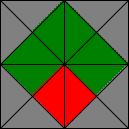

**Randomized (input for solving)**

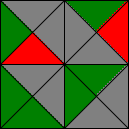

In [3]:
from IPython.display import display, Image, Markdown

display(Markdown('**Original**'), Image('area_orig.png'))
display(Markdown('**Randomized (input for solving)**'), Image('area.png'))

In [4]:
!minisat.sh

start Thu Jan 23 11:57:11 2025

SAT... OK

konec Thu Jan 23 11:57:11 2025

trvani 00:00:00
sat2cnf... findChildren(root)
sat2cnf... cnf_write
sat2cnf OK
minisat
==================================[MINISAT]===================================
| Conflicts |     ORIGINAL     |              LEARNT              | Progress |
|           | Clauses Literals |   Limit Clauses Literals  Lit/Cl |          |
|         0 |     708     2712 |     236       0        0     nan |  0.000 % |
restarts              : 1
conflicts             : 2              (936 /sec)
decisions             : 25             (11699 /sec)
propagations          : 459            (214787 /sec)
conflict literals     : 4              (0.00 % deleted)
Memory used           : 1.69 MB
CPU time              : 0.002137 s

SATISFIABLE
minisat_correct
cnf2sat...
cnf2sat OK
start Thu Jan 23 11:57:11 2025

ziskani plochy ze SAT reseni... OK

konec Thu Jan 23 11:57:11 2025

trvani 00:00:00


**Solved the old way**

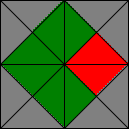

In [5]:
!display.sh area_sat_result.area area_sat_result.png
display(Markdown('**Solved the old way**'), Image('area_sat_result.png'))

## Qiskit

This library from IBM for QC looks easy to use, already having support for logical formulas built in, although API changes a lot and online examples are often non-working with the current version.

In [ ]:
!pip install qiskit[visualization] tweedledum qiskit_aer qiskit-algorithms

In [7]:
from qiskit.circuit.library import PhaseOracle
from qiskit.primitives import Sampler
from qiskit.visualization import plot_histogram
from qiskit_aer import Aer
from qiskit_algorithms import Grover, AmplificationProblem

In [8]:
%%script true
# This would unfortunately kill the kernel, overloading it, too big to fit into 8 GB of RAM.
oracle = PhaseOracle.from_dimacs_file('cnf.txt')

## SymPy

A handy library for processing of (logical) formulas, capable even of solving them.

In [ ]:
!pip install sympy

In [10]:
# Converting Simplify's prefix notation to a SymPy object
# which can easily produce infix notation for QC.

import collections
import sympy

def load_sat():
    with open('sat.txt') as f:
        sat = f.read()

    q = []

    def close_last_op(q):
        operands = collections.deque()
        while q and not isinstance(q[-1], sympy.core.function.FunctionClass):
            operands.appendleft(q.pop())

        op = q.pop()
        q.append(op(*operands))

    for word in sat.replace('(', ' ( ').replace(')', ' ) ').split():
        match word:
            case '(': ...  # no need to do anything here
            case ')': close_last_op(q)
            case 'AND': q.append(sympy.logic.And)
            case 'OR': q.append(sympy.logic.Or)
            case 'NOT': q.append(sympy.logic.Not)
            case _: q.append(sympy.symbols(word))

    assert len(q) == 1
    return q[0]

statement = load_sat()

In [11]:
%%script true
# This would also unfortunately kill the kernel.
oracle = PhaseOracle(str(statement))

## Maximal running example

So what's the biggest example which can be simulated on a standard CPU? Let's check how many qubits are supported by the backend:

In [12]:
Aer.get_backend('qasm_simulator').configuration().n_qubits

28

And how many logical variables does our formula have?

In [13]:
len(statement.atoms())

84

## At least some formula solvable by QC simulation

In [14]:
def solve_statement(statement):
    atoms = sorted(str(atom) for atom in statement.atoms())
    oracle = PhaseOracle(str(statement), var_order=atoms)
    problem = AmplificationProblem(oracle)
    sampler = Sampler()
    grover = Grover(sampler=sampler, iterations=1)
    result = grover.amplify(problem)
    # print(result.iterations, result.circuit_results)
    print(result.top_measurement, result.max_probability)
    # plot_histogram(result.circuit_results)
    
    solution = statement
    # Not sure why it gives the result in the reversed order
    for symb, res in zip(atoms, result.top_measurement[::-1]):
        val = bool(int(res))
        print(f'{symb} == {val}')
        solution = solution.subs(symb, val)
    if not solution:
        print(f'ERROR? It seems QC did not find a solution: {solution}')
    
    return oracle, result, solution

In [15]:
x, y, z = sympy.symbols('x y z')
statement = (x | y | z) & (x | ~y) & (y | ~z)
statement

(x | ~y) & (y | ~z) & (x | y | z)

001 0.2812499999999996
x == True
y == False
z == False


/tmp/ipykernel_100735/1626976846.py:5: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()


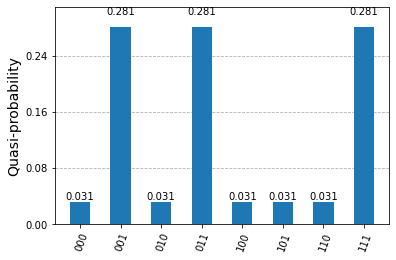

In [16]:
oracle, res, solved = solve_statement(statement)
plot_histogram(res.circuit_results)

In [17]:
# Schema of the quantum circuit
oracle.draw()

q_0: ─■──■─
      │  │ 
q_1: ─■──┼─
      │  │ 
q_2: ─■──o─

### Bigger formula

In [18]:
a, b, c, d, e, f = sympy.symbols('a b c d e f')
statement = (a | b | e) & (a | ~c) & (d | ~f) & (c | ~f) & (b | ~e)
statement

(a | ~c) & (b | ~e) & (c | ~f) & (d | ~f) & (a | b | e)

/tmp/ipykernel_100735/1626976846.py:5: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()


101101 0.0513305664062498
a == True
b == False
c == True
d == True
e == False
f == True


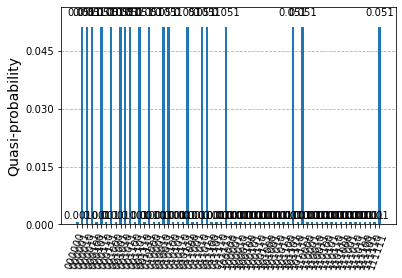

In [19]:
oracle, res, solved = solve_statement(statement)
plot_histogram(res.circuit_results)

In [20]:
oracle.draw()

q_0: ─o──o──o──────────o─────────────────────────
      │  │  │          │                         
q_1: ─■──■──o──■───────o───────■─────────────────
      │  │  │  │       │       │                 
q_2: ─■──■──■──■───────┼───────┼───────────────■─
      │  │  │  │       │       │               │ 
q_3: ─■──┼──■──■───────┼───────┼───────────────■─
      │  │  │  │       │       │               │ 
q_4: ─┼──┼──o──■───────o───────■───────o───────o─
      │  │  │  │ ┌───┐ │ ┌───┐ │ ┌───┐ │ ┌───┐ │ 
q_5: ─■──o──■──■─┤ X ├─■─┤ X ├─o─┤ X ├─■─┤ X ├─■─
                 └───┘   └───┘   └───┘   └───┘

### Maximal size of QC simulation

In [21]:
%%script true

size = 25

print(f'Checking {size}...')
statement = sympy.symbols('x')
for i in range(1, size):
    statement &= sympy.symbols(f'x{i}')
#sympy.logic.satisfiable(statement)
oracle, res, solved = solve_statement(statement)

29, 28, 27, 26 => Kernel died. (8 GB RAM, 4 CPU threads)

25 => That worked.

## Off-topic: solving Eternity just with SymPy, no QC

In [22]:
statement = load_sat()
solution = sympy.logic.satisfiable(statement)
assert solution
with open('sat_result.txt', 'w') as f:
    f.writelines(str(key) + '\n' for key, val in solution.items() if val)

In [23]:
!eternity unsat

start Thu Jan 23 11:57:22 2025

ziskani plochy ze SAT reseni... OK

konec Thu Jan 23 11:57:22 2025

trvani 00:00:00


**Solved**

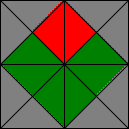

In [24]:
!display.sh area_sat_result.area area_sat_result2.png
display(Markdown('**Solved**'), Image('area_sat_result2.png'))